## **PRONOSTICADOR DE ENFERMEDADES**

**Integrantes**



*   Oscar Julian Rodriguez Cardenas
*   David Felipe Villamil Moscoso
*   Jhon Steven Garzón Cáceres


**Objetivo General**
*   Recomendar medicamentos para distintas enfermedades por medio de machine learning.

**Objetivo especifico**
*   Enseñarle a al modelo como distingar las distintas enfermedades
*   Mostrarle al modelo reseñas de las personas con las cuales hallar una relación



**Introducción**

La inteligencia artificial ha sido una busqueda de la humanidad con el objetivo de conseguir una herramienta la cual nos ayude a vivir de manera mas comoda, siendo utiliza en distintos medios como asistente en conducción, ciberseguridad, infraestructuras inteligentes, entre muchas otras, de las cuales tambien esta la medicina, en una busqueda de poder identificar enfermedades, anormalidades o asistente en los procesos medicos.

Por medio de un modelo de ML con una base de datos confiable se puede conseguir un asistente el cual consiga recomendar medicamentos en base a la enfermedad que tenga en base a los diagnosticos dados a distintas personas.

# Librerias

In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import re
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Primeramente se cargará la base de datos que se encuentra en formato tsv.Se cargará en un Dataframe de Pandas.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IAMedicos/drugsComTrain_raw.tsv',delimiter='\t',encoding='utf-8')

In [4]:
dfClean = df.copy()

Un primer vistazo a la base de datos:

In [5]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


Esta base de datos se compone de 161297 entradas y 7 columnas

**¿De donde sale la base de datos?**

El dataset es extraida del UCI Maching Learning Repository, la información son opiniones informales de personas en el sitio online drugs.com.

https://www.drugs.com/
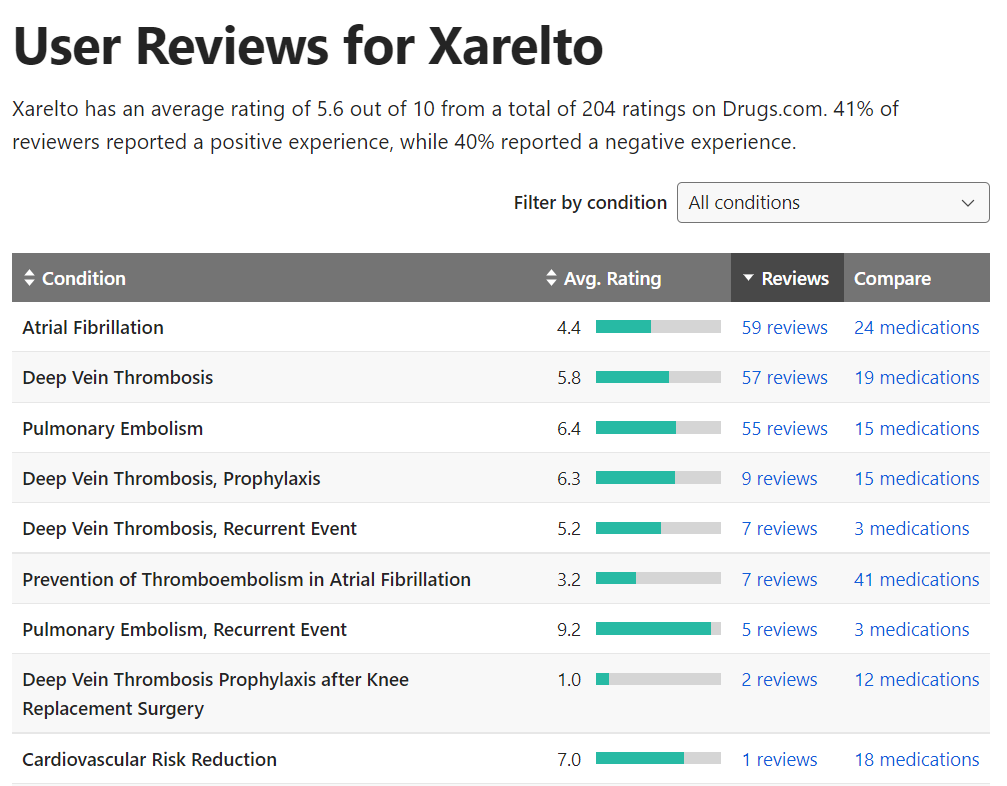

In [6]:
df.shape

(161297, 7)

El nombre de las columnas de la base de datos:

In [7]:
df.columns

Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

# Estadisticas básicas

¿Cuáles son las palabras más comunes de la columna 'Review'?

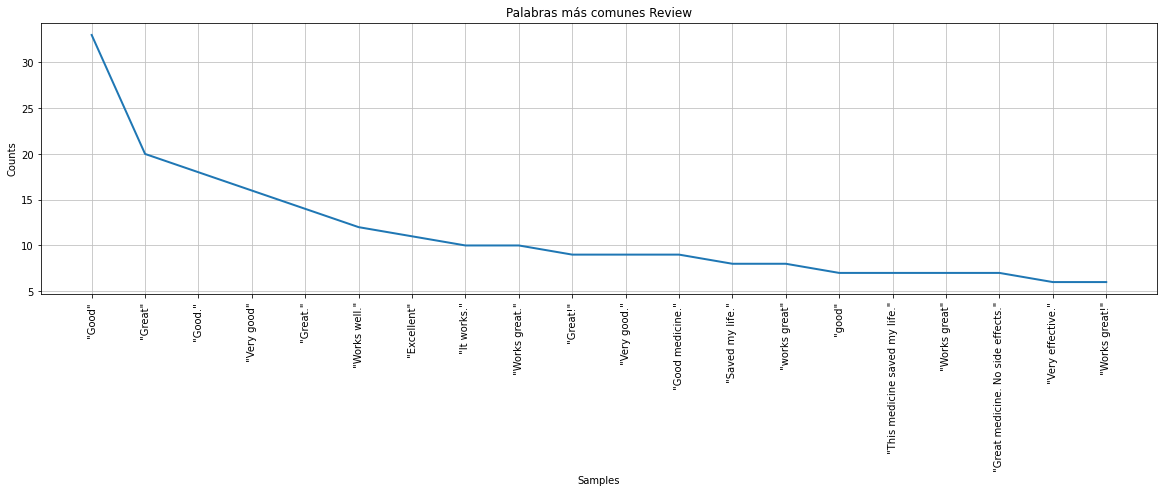

In [8]:
fdist = nltk.FreqDist(dfClean['review'])
fdist.most_common(20)

fig,ax = plt.subplots(figsize=(20,5))
ax.set_title('Palabras más comunes Review')
fdist.plot(20)
plt.show()

¿Cuáles son las palabras más comunes de la columna 'condition'?

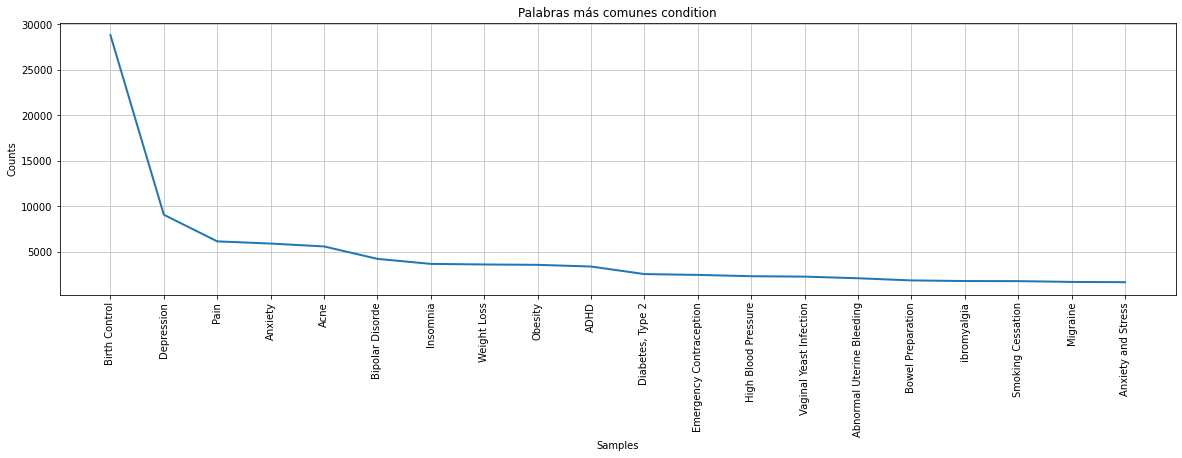

In [9]:
fdist = nltk.FreqDist(dfClean['condition'])
fdist.most_common(20)
fig,ax = plt.subplots(figsize=(20,5))
ax.set_title('Palabras más comunes condition')
fdist.plot(20)
plt.show()

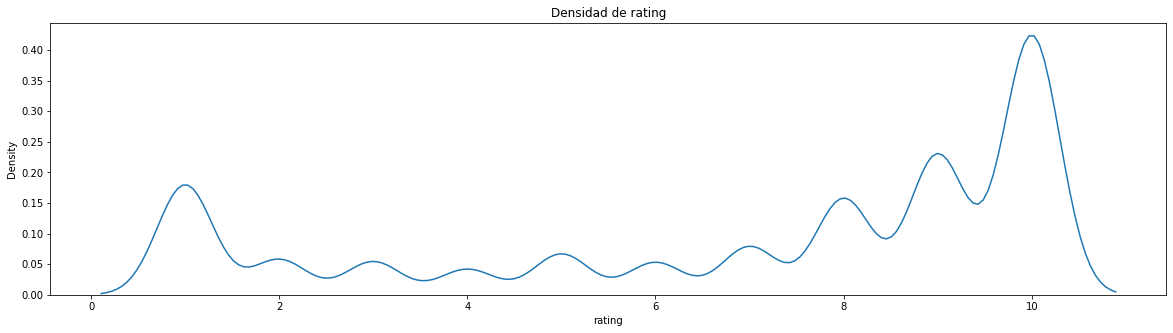

In [10]:
fig,ax = plt.subplots(figsize=(20,5))
sns.kdeplot(data=dfClean, x = 'rating')
plt.title('Densidad de rating')
plt.show()

## Data cleaning

Ahora como la base de datos fue extraida mediante web scrapping está 'sucia', se procederá a quitar algunos caracteres que no son propiamente del texto.

In [11]:
# Visualizar columna review para ver caracteres no deseados.
for i in range(dfClean.shape[0]):
  print(dfClean['review'].iloc[i])

In [12]:
# Remover filas vacias.
dfClean.dropna(inplace = True)

In [13]:
# Se remueve la palabra  'span'.
dfClean = dfClean.drop(dfClean[dfClean['condition'].str.contains("span")].index)

# Se remueven los caracteres '\r', '\n', '&amp', '&#039;', '&quot;'
dfClean['review'] = dfClean['review'].str.replace('\r','').str.replace('\n','').str.replace('&amp','').str.replace('&#039;','').str.replace('&quot;','')

In [14]:
dfClean['raitng'] = df['rating'].astype('float')

Después de la limpieza la base de datos ahora se compone de 159498 entradas.

In [15]:
dfClean.shape

(159498, 8)

Ahora se le asignará a cada condición un número, es decir, a la variable que se busca predecir.

In [16]:
enc = OrdinalEncoder()
enc.fit(dfClean[['condition']])
dfClean['integerCondition'] = enc.transform(dfClean[['condition']])

Se removerán stopwords y se hará radicalización (stemming):

In [ ]:
st = stopwords.words('english')
stemmer = PorterStemmer()
dfClean['cleanedReview'] = dfClean['review'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ",x).split() if i not in st]).lower())
dfClean

Ahora se separa entre la variable predictora (X) que en este caso es la 'review' dada por el paciente y la variable a predecir (y) que en este caso es la condición.

In [ ]:
X = dfClean['cleanedReview']
y = dfClean['integerCondition']

Ahora se dividirán los datos entre train y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [ ]:
from sklearn.linear_model import SGDClassifier
vectorizer = TfidfVectorizer()
clf =  SGDClassifier(loss='modified_huber', max_iter=5, tol=None)

In [ ]:
dfClean.head()

**¿Que es el SGDClassifier?**

SGDClassifer es un clasificador que es facil de usar y que presento los mejores resultados respecto a otros clasificadores. Aunque la precision no es muy alta, la precision y la memoria estan bastante equilibradas.

**¿Que es TfidfVectorizer?**

Dado que los modelos de clasificación tienen que trabajar en números y no en palabras, necesitamos convertir el texto en números de alguna manera. Esto se llama vectorización. Un enfoque popular para vectorizar texto en el procesamiento del lenguaje natural es utilizar el vectorizador TF-IDF.



In [ ]:
pipeline = Pipeline([('vect', vectorizer),
                     ('clf', clf)])

model = pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

ytest = np.array(y_test)
y_hat = model.predict(X_test)
print(f"El accuracy alcanzado fué de {accuracy_score(y_test, y_hat)}")

In [ ]:
!pip install beautifulsoup4
!pip install google

from googlesearch import search
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def IA_enfermedades():

  p = "j"
  while(p != "exit"):
    print("Please enter your condition: ")
    p = input()

    if p == 'exit':
      print("Exiting!")
      break

    resultInteger = model.predict([p])
    n = int(resultInteger[0])
    condition = enc.categories_[0][n]

    print("-----------------------------------------------------------------------------------------------")
    print(f"Possible condition recognized: {condition}")
    print("-----------------------------------------------------------------------------------------------")
   
    # información
    print("These are some links to read about your condition")
    results = search(condition)
    c = list(results)[0]
    print(c)
    
    #Medicamentos
    drugs = dfClean[dfClean.condition.str.contains(condition)][dfClean['rating'] == 10]['drugName'].unique()[:5] 
    print(f"Top medications for {condition}:")
    for d in drugs:
      print(d)
    print("-----------------------------------------------------------------------------------------------")
    print("-----------------------------------------------------------------------------------------------")


  

In [ ]:
IA_enfermedades()

Please enter your condition: 
-----------------------------------------------------------------------------------------------
Possible condition recognized: Tonsillitis/Pharyngitis
-----------------------------------------------------------------------------------------------
These are some links to read about your condition
https://www.hopkinsmedicine.org/health/conditions-and-diseases/pharyngitis-and-tonsillitis
Top medications for Tonsillitis/Pharyngitis:
Azithromycin
Cefdinir
Zithromax
Amoxicillin
Penicillin v potassium
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Please enter your condition: 
-----------------------------------------------------------------------------------------------
Possible condition recognized: ADHD
-----------------------------------------------------------------------------------------------
These are some links